# GPU Check

In [1]:
DEBUG = True
#DATA_PATH = '../../dataset/part1/'
DATA_PATH = '../../dataset/face_labeled_data/train'
BATCH_SIZE = 32
import torch
import math
print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

# Dataset

In [2]:
import os
import PIL.Image as Image
import numpy as np
from os import listdir
from os import walk
import glob
from torch.utils.data import Dataset
from torchvision import transforms

import simsiam.loader

img_size = (224, 224)

class FaceImages(Dataset):
    
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_path_list = glob.glob(os.path.join(img_dir, '**/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        img = FaceImages.read_image(img_path)
        return self.transform(img), self.transform(img)
    
    @staticmethod
    def read_image(img_path):
        #return cv2.imread(img_path)
        return Image.open(img_path, mode='r').convert('RGB')

# Data augmentation

In [3]:
import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          
def get_aug_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

aug = get_aug_trnsform(0.5)

# dataloader test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

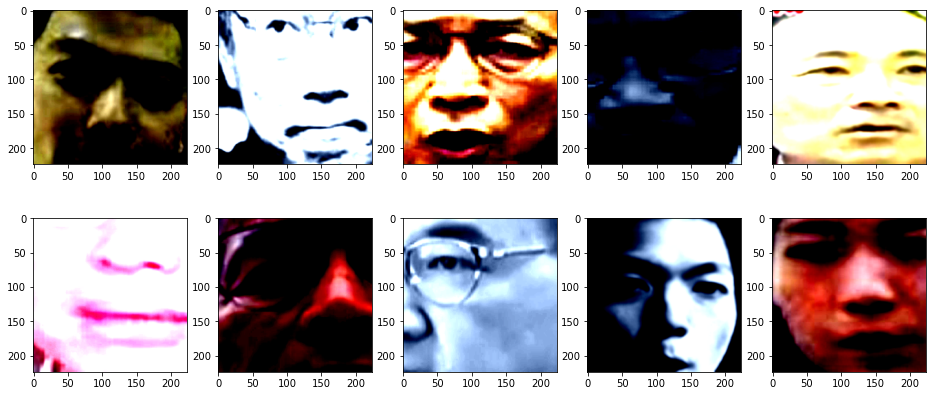

In [4]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

if DEBUG:
    dataset = FaceImages(DATA_PATH, aug)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    faces1, faces2 = next(iter(dataloader))

    ROW, COL = 2, 5
    f, ax = plt.subplots(ROW, COL, figsize=(16, 7))
    for i in range(ROW):
        for j in range(COL):
            img = faces1[i*COL+j]
            ax[i][j].imshow(img.permute(1, 2, 0))
    plt.show()

# Build Model

In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
# batch size
batch_size = BATCH_SIZE
# learning rate
init_learning_rate = 0.05 * batch_size / 256
momentum_val = 0.9
weight_decay_val = 1e-4

In [9]:
import torchvision.models as models
from torch import nn

# backbone
backbone = models.resnet50(pretrained=True)
backbone.to(device)
# projector
projector = nn.Sequential(
    nn.Linear(1000, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
    nn.Linear(2048, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
    nn.Linear(2048, 2048),
) 
projector.to(device)
# predictor
predictor = nn.Sequential(
    nn.Linear(2048, 512), nn.BatchNorm1d(512), nn.ReLU(),
    nn.Linear(512, 2048),
)
predictor.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/me/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=2048, bias=True)
)

# optim 新增momentum_val 和 weight_decay

In [10]:
# optimizer
from torch import optim
optim_params_backbone = [{'params': backbone.parameters(), 'fix_lr': False}]
optim_params_projector = [{'params': projector.parameters(), 'fix_lr': False}]
optim_params_predictor = [{'params': predictor.parameters(), 'fix_lr': True}]

backbone_opt = optim.SGD(optim_params_backbone, lr=init_learning_rate, momentum = momentum_val, weight_decay = weight_decay_val)
projector_opt = optim.SGD(optim_params_projector, lr=init_learning_rate, momentum = momentum_val, weight_decay = weight_decay_val)
predictor_opt = optim.SGD(optim_params_predictor, lr=init_learning_rate, momentum = momentum_val, weight_decay = weight_decay_val)

# save model

In [11]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# 動態lr

In [12]:
def adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

# Train

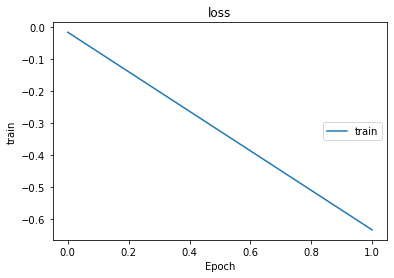

163it [02:03,  1.30it/s]

In [ ]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 

dataset = FaceImages(DATA_PATH, aug)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epoch = 100

loss_history = []
def update_loss_hist(is_end):
    clear_output(wait=True)
    
    plt.plot(loss_history)
    plt.title('loss')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='center right')
    if (is_end):
        plt.savefig('result.png')
    plt.show()
    
def D(p, z):
    z = z.detach() # stop gradient
    return -(nn.functional.cosine_similarity(p, z).mean())

# train loop
for i in range(epoch):
    adjust_learning_rate(backbone_opt, init_learning_rate, i, epoch)
    adjust_learning_rate(projector_opt, init_learning_rate, i, epoch)
    adjust_learning_rate(predictor_opt, init_learning_rate, i, epoch)

    for j, image_batch in tqdm(enumerate(dataloader)):
        x1, x2 = image_batch[0].to(device), image_batch[1].to(device)
        # forward
        y1, y2 = backbone(x1), backbone(x2)
        z1, z2 = projector(y1), projector(y2)
        p1, p2 = predictor(z1), predictor(z2)
        
        # compute loos
        L = (D(p1, z2) + D(p2, z1))/2 # loss
        
        # epoch 0 loss histogram
        if len(loss_history)==0:
            loss_history.append(L.item())
            update_loss_hist(False)
            
        # update
        backbone_opt.zero_grad()
        projector_opt.zero_grad()
        predictor_opt.zero_grad()
        L.backward()
        backbone_opt.step()
        projector_opt.step()
        predictor_opt.step()
    
    loss_history.append(L.item())
    update_loss_hist(False)

    save_checkpoint({
        'epoch': i + 1,
        'arch': 'resnet50',
        'state_dict': backbone.state_dict(),
        'optimizer' : backbone_opt.state_dict(),
    }, is_best=False, filename='./model/checkpoint_backbone_{:04d}.pth.tar'.format(i + 1))
    save_checkpoint({
        'epoch': i + 1,
        'arch': 'resnet50',
        'state_dict': projector.state_dict(),
        'optimizer' : projector_opt.state_dict(),
    }, is_best=False, filename='./model/checkpoint_projector_{:04d}.pth.tar'.format(i + 1))
update_loss_hist(True)